In this part, the goal is to create new representations for features,

In [67]:
import pandas as pd

In [68]:
data = pd.read_csv('hour_pre.csv')

In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [69]:
data.columns

Index(['date', 'season', 'year', 'month', 'hour', 'holiday', 'weekday',
       'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
       'casual', 'registered', 'total_count', 'total_count_smoothed_kalman'],
      dtype='object')

In [70]:
data['date'] = pd.to_datetime(data['date'])
data['season'] = data.season.astype('category')
data['month'] = data.month.astype('category')
data['holiday'] = data.holiday.astype('category')
data['weekday'] = data.weekday.astype('category')
data['workingday'] = data.workingday.astype('category')
data['weather'] = data.weather.astype('category')

In [71]:
data.weather.replace((1,2,3,4), ('Clear, Few clouds, Partly cloudy, Partly cloudy','Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist','Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds','Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'), inplace=True)


In [72]:
data['weather']

0          Clear, Few clouds, Partly cloudy, Partly cloudy
1          Clear, Few clouds, Partly cloudy, Partly cloudy
2          Clear, Few clouds, Partly cloudy, Partly cloudy
3          Clear, Few clouds, Partly cloudy, Partly cloudy
4          Clear, Few clouds, Partly cloudy, Partly cloudy
                               ...                        
14905    Mist + Cloudy, Mist + Broken clouds, Mist + Fe...
14906    Mist + Cloudy, Mist + Broken clouds, Mist + Fe...
14907      Clear, Few clouds, Partly cloudy, Partly cloudy
14908      Clear, Few clouds, Partly cloudy, Partly cloudy
14909      Clear, Few clouds, Partly cloudy, Partly cloudy
Name: weather, Length: 14910, dtype: category
Categories (4, object): ['Clear, Few clouds, Partly cloudy, Partly cloudy', 'Mist + Cloudy, Mist + Broken clouds, Mist + F..., 'Light Snow, Light Rain + Thunderstorm + Scatt..., 'Heavy Rain + Ice Pallets + Thunderstorm + Mis...]

##### Correlation based Feature selection

In [73]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

numerical_data = data.select_dtypes(include=[np.number])
numerical_data.drop(['year','hour'],inplace=True, axis=1)

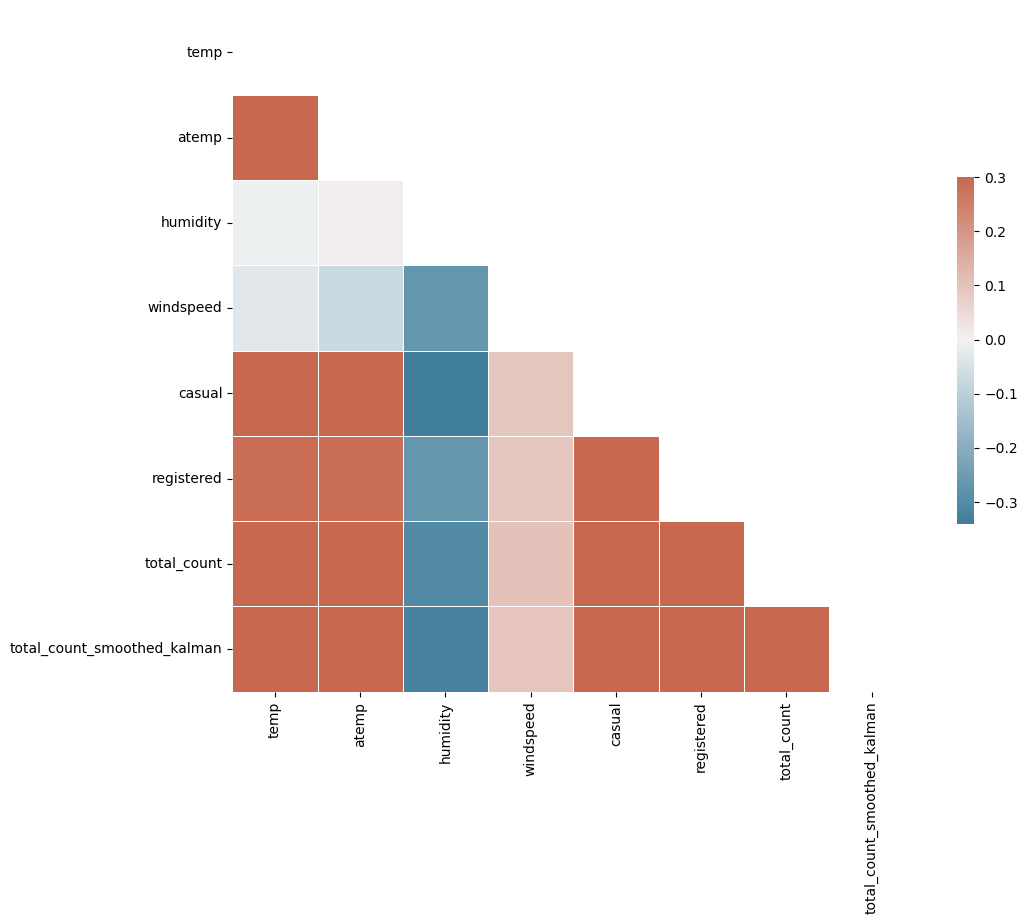

In [74]:


corr = numerical_data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


Les features a enlever : 
- windspeed : tres faible correlattion avec total count
- atemp : une sorte de redondance avec temp 
- date : vaut mieux qu'elle soit fragmentee en plusieurs colonnes
On aurait pu croire ue weekday et working day contiennent des informations redondante sauf que non, il se peut qu'un working day soit un weekend et vice versa.

In [75]:
nd = numerical_data.copy()

In [76]:
nd.columns

Index(['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered',
       'total_count', 'total_count_smoothed_kalman'],
      dtype='object')

In [77]:
def select_features(df, target, threshold):
    correlations = df.corr()[target]
    selected_features = correlations[correlations.abs() > threshold].index.tolist()
    selected_features.remove(target)  
    return selected_features

selected_features = select_features(numerical_data, 'total_count', 0.15)
print("Selected features:", selected_features)


Selected features: ['temp', 'atemp', 'humidity', 'casual', 'registered', 'total_count_smoothed_kalman']


In [78]:
### on fragmente date
### Fragmentation de la date
# Ceci va ecraser month et year, et tant mieux 
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

In [79]:
data.columns

Index(['date', 'season', 'year', 'month', 'hour', 'holiday', 'weekday',
       'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
       'casual', 'registered', 'total_count', 'total_count_smoothed_kalman',
       'day'],
      dtype='object')

On cree un feature interaction of humiity and speed because in day.csv humidity has little correlation and in hour.csv windspeed is not important

In [80]:
df_oh = data.drop(['date','atemp'], axis=1)
df_oh['humidity_windspeed'] = data['humidity'] * data['windspeed']
df_oh = df_oh.drop(['humidity','windspeed'], axis=1)
df_oh.head(-5)

,season,year,month,hour,holiday,weekday,workingday,weather,temp,casual,registered,total_count,total_count_smoothed_kalman,day,humidity_windspeed
0,1,2011,1,0,0,6,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,3,13,16,14.026656,1,0.000000
1,1,2011,1,1,0,6,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,8,32,40,26.079968,1,0.000000
2,1,2011,1,2,0,6,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,5,27,32,24.213248,1,0.000000
3,1,2011,1,3,0,6,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,3,10,13,14.559775,1,0.000000
4,1,2011,1,4,0,6,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0,1,1,6.466077,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14900,1,2012,12,14,0,1,1,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.28,62,185,247,239.349175,31,0.100755
14901,1,2012,12,15,0,1,1,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.28,69,246,315,256.094148,31,0.060435
14902,1,2012,12,16,0,1,1,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.26,30,184,214,213.933269,31,0.093120
14903,1,2012,12,17,0,1,1,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.26,14,150,164,171.705658,31,0.043008


Une autre alternative de l'action de suppression de l'attribut windspeed car il a une faible correlation avec count,  atemp car c'est pratiquement la meme chose que temp, aurait ete de creer un attribut d'interaction qui represente le produit de ces deux la.

Codification des variables categorielle : One hot encoding

For one hot encoding, get_dummies  a bad idea because it created instances based on values on you dataset.

Maintenant, toujours dans le one hot encoding, nous allons travailler particulierement sur la colonne weather, chaque instance contient plusieurs etat donc on va encoder a chaud chaque etat.

In [81]:
import pandas as pd
import numpy as np

def custom_one_hot_encoder(df, cols, min_values, max_values):
    df_copy = df.copy()
    for col in cols:
        for i in range(min_values[col], max_values[col]+1):
            df_copy[col + '_' + str(i)] = np.where(df_copy[col] == i, 1, 0)

    df_copy = df_copy.drop(cols, axis=1)

    return df_copy

cols = ['season','month','hour','weekday']
min_values = {'season': 1, 'month': 1, 'hour': 0, 'weekday': 0}
max_values = {'season': 4, 'month': 12, 'hour': 23, 'weekday': 6}

df_final = custom_one_hot_encoder(df_oh, cols, min_values, max_values)
df_final.columns

Index(['year', 'holiday', 'workingday', 'weather', 'temp', 'casual',
       'registered', 'total_count', 'total_count_smoothed_kalman', 'day',
       'humidity_windspeed', 'season_1', 'season_2', 'season_3', 'season_4',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6'],
      dtype='object')

In [82]:
df_oh = df_final.copy()

In [83]:
weather_states = ['Clear', 'Few clouds', 'Partly cloudy', 'Mist', 'Cloudy', 'Broken clouds', 'Light Snow', 'Light Rain', 'Thunderstorm', 'Scattered clouds', 'Heavy Rain', 'Ice Pallets', 'Snow', 'Fog']
for state in weather_states:
    df_oh[state] = df_oh['weather'].apply(lambda x: 1 if state in x else 0)

df_oh = df_oh.drop(columns=['weather'])

In [84]:
df_oh.columns

Index(['year', 'holiday', 'workingday', 'temp', 'casual', 'registered',
       'total_count', 'total_count_smoothed_kalman', 'day',
       'humidity_windspeed', 'season_1', 'season_2', 'season_3', 'season_4',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'Clear', 'Few clouds', 'Partly cloudy', 'Mist', 'Cloudy',
       'Broken clouds', 'Light Snow', 'Light Rain', 'Thunderstorm',
       'Scattered clouds', 'Heavy Rain', 'Ice Pallets', 'Snow', 'Fog'],
      dtype='object')

In [85]:
ordered_cols = ['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 
                'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 
                'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 
                'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
                'day','month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
                'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
                'year','weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 
                'weekday_5', 'weekday_6', 'holiday', 'workingday', 'temp', 'humidity_windspeed', 
                'season_1', 'season_2', 'season_3', 'season_4', 
                'Clear', 'Few clouds', 'Partly cloudy', 
                'Mist', 'Cloudy', 'Broken clouds', 'Light Snow', 'Light Rain', 
                'Thunderstorm', 'Scattered clouds', 'Heavy Rain', 'Ice Pallets', 'Snow', 'Fog',
                'casual','registered', 'total_count', 'total_count_smoothed_kalman']

df_final = df_oh[ordered_cols]
df_final.head()

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,Thunderstorm,Scattered clouds,Heavy Rain,Ice Pallets,Snow,Fog,casual,registered,total_count,total_count_smoothed_kalman
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,13,16,14.026656
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8,32,40,26.079968
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,27,32,24.213248
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,3,10,13,14.559775
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,6.466077


In [86]:
## Now we check relation betweem weekdays and workingday 

weekday_mask = (df_final['weekday_0'] == 1) | (df_final['weekday_1'] == 1) | (df_final['weekday_2'] == 1) | (df_final['weekday_3'] == 1) | (df_final['weekday_4'] == 1 | (df_final['weekday_5'] == 1)) | (df_final['weekday_6'] == 1)

workingday_mask = df_final['workingday'] == 1

common_days = df_final[weekday_mask & workingday_mask]

weekday_columns = ['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']

common_days_weekdays = common_days[weekday_columns]

common_days[weekday_columns].nunique()

weekday_0    1
weekday_1    2
weekday_2    2
weekday_3    2
weekday_4    2
weekday_5    1
weekday_6    1
dtype: int64

In [87]:
# so working day can be any day not just weekend so we do not take off the feature.

In [88]:
df_final.to_csv('hour_final.csv', index=False)

In [ ]:
Codage des variables catégorielles (saison, météo) pour les convertir en format numérique utilisable dans les modèles statistiques.